## Import Libraries


/pfs/data5/home/kit/stud/updzl


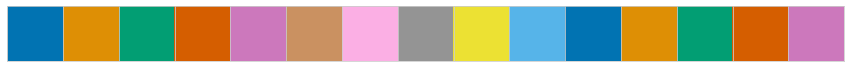

In [1]:
###
# Ralf Loritz 15.2.2022
# Rainfall-runoff using LSTM Models
# Pytorch
###
%load_ext autoreload
%autoreload 2 #Reload all modules every time before executing the Python code typed.

# built-in
import os
import importlib
import math
import datetime

###
# addtional packages
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# import pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data_utils

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# set torch seed
#torch.manual_seed(42)

# import from sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

###
# set plot style seaborn
sns.set_style("whitegrid")

# set colors
current_palette = sns.color_palette("colorblind", 15)
sns.palplot(current_palette)
# set workspcae
os.chdir('./')
print(os.getcwd())

In [2]:
#drive.mount('/content/drive')

###
# identify GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
# set cuda0 as GPU
cuda0 = torch.device('cuda:0')
cuda1 = torch.device('cuda:1')

1
Tesla V100-SXM2-32GB


## LSTM model


In [3]:
# 22.04.22 
# LSTM model taken from Ralfs version 1.1
# Reviewed by Jean-Paul 26.04.22


class ShallowRegressionLSTM(nn.Module):                                                                       # define new class which inherits from the nn.Module                                           
    def __init__(self, input_size, hidden_size, num_layer, drop_out):                                                   # define constructor, includes objects attributs which must be defined when instantiating given object
        super().__init__()                                                                                    
        self.input_size = input_size                                                                          # this is the number of features
        self.hidden_size = hidden_size                                                                        # number of nodes per layer (identical layer size over ll layers, otherwise multiple attributes for hidden size )
        self.num_layers = num_layer                                                                           # number of layers per instantiated nn.LSTM (1 here)
        #self.drop_out = drop_out
        
        self.lstm_1 = nn.LSTM(input_size = input_size,
                              hidden_size = hidden_size,
                              batch_first = True,
                              num_layers=num_layer,
                              #drop_out = drop_out
                             )
        #self.lstm_2 = nn.LSTM(input_size = hidden_size,                                                       # input for the second layer is the output of the previous layer i.e. the hidden states of the previous layer (size=hiden_size)
         #                     hidden_size = hidden_size,
          #                    batch_first = True,
           #                   num_layers=num_layer)
            
        self.dropout = torch.nn.Dropout(drop_out)                                                             # dropout layer for regualitation http://jmlr.org/papers/v15/srivastava14a.html
        
        
        self.linear = nn.Linear(in_features=self.hidden_size,                                                 # linear or so called Dense-layer, which takes hidden states from previous layer (size=lstm_2(hidden_size)) as input and calculates an output (size=output_features) with linear transformation (y=W*x+b)
                                out_features=1)                                                               # and calculates an output (size=output_features) with linear transformation (y=W*x+b)           

        
    def forward(self, x):
        batch_size = x.shape[0]
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(cuda0)            # initial hidden_states with zeros, requires_grad let pytorch track operations on tensor, to(cuda0) moves tensor to your device (here: GPU)
        #h1 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(cuda0)            # initial cell states
        
        # initialize the cell state:
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(cuda0)
        #c1 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(cuda0)
        
        out, (hn_1, cn_1) = self.lstm_1(x, (h0.detach(), c0.detach()))                                        # out: batch_size, sequence_length, hidden_size; h_n & c_n: num_layers, hidden_size
        #out = self.dropout(out)                                                                               # detach????
        #out, (hn_2, cn_2) = self.lstm_2(out, (h1.detach(), c1.detach()))                                      
        out = out[:,-1,:]                                                                                     # many to one / sequence to one
        out = self.dropout(out)
        out = self.linear(out)  # First dim of Hn is num_layers, which is set to 1 above.

        return out, (hn_1.transpose(0,1), cn_1.transpose(0,1)),
                    #(hn_2.transpose(0,1), cn_2.transpose(0,1)
                    

## Functions & Objects


In [4]:
# Preprocessing etc.


# Creates a training, validation and test data set
# Check https://onlinelibrary.wiley.com/doi/abs/10.1029/2021WR031523 for split sampling approaches in hydrological modeling
# Validation period is usually very small and is used to check the performance of the model during the training on a out-of-sample batch
# to monitor evtl. overfitting
def split_data(start_train, end_train, start_val, end_val, start_test, end_test, df):
  ''' split data set into training period, validation period (for hyperparameter tuning) and independent test period.
  periods should correlate with benchmark model. 
  input in date time format or any other indexing used in df(dataframe)'''
  train = df.loc[start_train:end_train]
  val = df.loc[start_val:end_val]
  test = df.loc[start_test:end_test]
  return train, val, test

# Standardizes data for the network, to avoid scaling issues. Uses own metrics.
def local_standartization(data):
  ''' z-standartisation on the the all the data, statistic values taken from training period'''
  stds = data.std()
  mean = data.mean()
  scaled_data = (data-mean)/stds
  return scaled_data, stds, mean

# Standartizes data for network with given metrics(from training data set)
def scale(data, stds, mean):
  scaled_data = (data-mean)/stds
  return scaled_data

# Performance metrics:
# NSE function
def get_nse(y_test, predictions):
  assert len(y_test) == len(predictions)  
  numerator = sum([(y_test[i]-predictions[i])**2 for i in range(len(y_test))])
  y_test_avg = sum(y_test)/len(y_test)
  denominator = sum([(y_test[i]-y_test_avg)**2 for i in range(len(y_test))])
  NSE = 1- (numerator/denominator)
  return NSE

# KGE 2009
def kge(simulations, evaluation):
    """Original Kling-Gupta Efficiency (KGE) and its three components
    (r, α, β) as per `Gupta et al., 2009
    <https://doi.org/10.1016/j.jhydrol.2009.08.003>`_.
    Note, all four values KGE, r, α, β are returned, in this order.
    :Calculation Details:
        .. math::
           E_{\\text{KGE}} = 1 - \\sqrt{[r - 1]^2 + [\\alpha - 1]^2
           + [\\beta - 1]^2}
        .. math::
           r = \\frac{\\text{cov}(e, s)}{\\sigma({e}) \\cdot \\sigma(s)}
        .. math::
           \\alpha = \\frac{\\sigma(s)}{\\sigma(e)}
        .. math::
           \\beta = \\frac{\\mu(s)}{\\mu(e)}
        where *e* is the *evaluation* series, *s* is (one of) the
        *simulations* series, *cov* is the covariance, *σ* is the
        standard deviation, and *μ* is the arithmetic mean.
    """
    # calculate error in timing and dynamics r
    # (Pearson's correlation coefficient)
    sim_mean = np.mean(simulations, axis=0, dtype=np.float64)
    obs_mean = np.mean(evaluation, dtype=np.float64)

    r_num = np.sum((simulations - sim_mean) * (evaluation - obs_mean),
                   axis=0, dtype=np.float64)
    r_den = np.sqrt(np.sum((simulations - sim_mean) ** 2,
                           axis=0, dtype=np.float64)
                    * np.sum((evaluation - obs_mean) ** 2,
                             dtype=np.float64))
    r = r_num / r_den
    # calculate error in spread of flow alpha
    alpha = np.std(simulations, axis=0) / np.std(evaluation, dtype=np.float64)
    # calculate error in volume beta (bias of mean discharge)
    beta = (np.sum(simulations, axis=0, dtype=np.float64)
            / np.sum(evaluation, dtype=np.float64))
    # calculate the Kling-Gupta Efficiency KGE
    kge_ = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

    return np.vstack((kge_, r, alpha, beta))

# Takes pandas df and lists with strings which denote target and feature columns, as well as a desired sequence length.
# inherits from pytorch Datafram function
# outputs a list containing 2 tensors: 1 with features (including the respective sequence) and 1 with the corresponding target(label)
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).to(cuda0).float()
        self.X = torch.tensor(dataframe[features].values).to(cuda0).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

## Import Data

data handling and preprocessing will happen only with numpy arrays and/or panda dataframes<br>
<br>
pytorch framework uses an own class for numerical values --> tensors <br>
torch.tensor includes a bunch of mathematical operations ranging from simple point to point operation to linear algebraic operations.<br>
<br>
however for simplicity and for the sake of overview for the timeseries the data is only converted after the preprocessing (slicing, standartization, etc.) into tensors which then are passed into the ANN models

In [5]:
# Create a drectory for  your datafiles which containes filenames 
data_directory = os.listdir(path='/pfs/data5/home/kit/stud/updzl/data')
print('Files found: '+str(data_directory))
data_directory.pop(2)
# Define the current folder with the files 
os.chdir('/pfs/data5/home/kit/stud/updzl/data')
# loop through the directory and load the dataframes directly into local memory. filenames become df names, the .replace method can
# change those names. check the read_csv method for argumentexplanations, they differ on the strucutre of your data set 
# (header = line of column names etc.)
for i in range(len(data_directory)):
   locals()[str(data_directory[i]).replace('inclERA5.txt', '')]= pd.read_csv(str(data_directory[i]), header=0, parse_dates=[0], index_col =[0])

Files found: ['HuewelerbachinclERA5.txt', 'SchwebichinclERA5.txt', '.ipynb_checkpoints', 'WeierbachinclERA5.txt', 'MierbechinclERA5.txt', 'BibeschbachinclERA5.txt']


In [6]:
catchment = Schwebich
catchment

,P_Useldange,T_Useldange,Q_Schwebich,Q_flag,EVAP_Useldange,T_flag,InterRecka,InterKoeri,InterMamer,InterRoodt,...,q,rh,tcwv,windspeed,LLS,DLS,swvl1,swvl2,swvl3,swvl4
Date,,,,,,,,,,,,,,,,,,,,,
2004-10-01 00:00:00,0.0,11.5,0.003289,0,0.038750,0,0,0,0,0,...,0.003672,79.529410,21.871196,10.868925,7.200403,18.308258,0.289412,0.263291,0.261994,0.335555
2004-10-01 00:30:00,0.0,11.4,0.003289,0,0.038542,0,0,0,0,0,...,0.003476,77.245507,22.097770,10.624766,6.584422,18.712995,0.290061,0.263328,0.262002,0.335555
2004-10-01 01:00:00,0.0,11.3,0.003289,0,0.038333,0,0,0,0,0,...,0.003280,74.961605,22.324345,10.380607,5.968441,19.117732,0.290711,0.263364,0.262010,0.335555
2004-10-01 01:30:00,0.0,11.3,0.003289,0,0.038333,0,0,0,0,0,...,0.003150,69.677415,22.636840,10.340025,5.436880,18.972278,0.295335,0.263425,0.262018,0.335548
2004-10-01 02:00:00,0.0,11.3,0.003289,0,0.038333,0,0,0,0,0,...,0.003020,64.393225,22.949334,10.299443,4.905319,18.826824,0.299960,0.263486,0.262026,0.335540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31 21:30:00,0.0,11.7,0.003630,0,0.057292,0,0,0,0,0,...,0.001662,28.650982,16.843666,10.036747,5.938585,12.699160,0.343970,0.347823,0.357567,0.379387
2021-08-31 22:00:00,0.0,10.8,0.003421,0,0.054167,0,0,0,0,0,...,0.001751,30.578195,17.154819,10.457367,6.118375,12.379778,0.343963,0.347823,0.357558,0.379379
2021-08-31 22:30:00,0.0,10.6,0.003313,0,0.053333,0,0,0,0,0,...,0.001743,30.532430,17.203814,10.638971,5.975072,12.025004,0.343955,0.347808,0.357551,0.379379


# Hyperparameters

In [7]:
# Define Hyperparameters in dictionary 
# check http://arxiv.org/abs/1206.5533 for a comrehensive overview over the different hyperparameters involved and their impact

model_params = {
  "batch_size": 512,
  "sequence_length": 512,
  "hidden_size": 256,            # set hidden_size of model i.e. number of nodes per hidden layer
  "num_layer":1,  
  "num_epochs": 5,                # number of training epochs, start high and use the validation dataset after each epoch to check the performance metric 
                                # on an out of batch example, choose the number of epoch with the best validation performance and not the best training
                                # performance
  "drop_out": 0.6,              # set drop_out of model for regularization
  "learning_rate": 0.0005,       # set learning rate which is responsible for how strongly the optimization algorithm adapts the model parameters after
                                # a training epoch
  "loss": torch.nn.MSELoss(),   # set loss function: regression task --> mean squared error, already defined in torch framework, possible to write own
  "set_forget_gate": 3,  
  "adapt_learning_rate_epoch": 1,
  "adapt_gamma_learning_rate": 0.2,
  "swa_start": 15,            # start stochastic weight averaging
  "swa_learning_rate": 0.0001,
  "grad_clip" : 'on',            # add gradient clipping
  "max_norm" : 1,                #define max gradient
}



In [8]:
# Define training and testing periods
start_train = '2010-10-01 00:00:00'
#start_train_dt = datetime.datetime.strptime(start_train, '%Y-%m-%d %H:%M:%S')
end_train = '2021-09-30 23:30:00'
start_val = '2009-10-01 00:00:00'
#start_val_dt = datetime.datetime.strptime(start_val, '%Y-%m-%d %H:%M:%S')
end_val = '2010-09-30 23:30:00'
start_test = '2004-10-01 00:00:00'
#start_test_dt = datetime.datetime.strptime(start_test, '%Y-%m-%d %H:%M:%S')
end_test = '2010-09-30 00:00:00'
#end_test_dt = datetime.datetime.strptime(end_test, '%Y-%m-%d %H:%M:%S')
# Define catchment i.e. the dataframe of interest
catchment = Bibeschbach
catchment_str = 'Bibeschbach'
experiment = 'A'




# Adding additional data (i.e. rainfall) from neighbouring catchments (stations)
#if catchment_str == 'Bibeschbach':
  #neighbouring_catchment_A = Mierbech
#  neighbouring_catchment_B = Schwebich
if catchment_str == 'Huewelerbach':
  neighbouring_catchment_A = Schwebich
  neighbouring_catchment_B = Weierbach
#elif catchment_str == 'Mierbech':
#  neighbouring_catchment_A = Bibeschbach
#  neighbouring_catchment_B = Schwebich
elif catchment_str == 'Weierbach':
  neighbouring_catchment_A = Huewelerbach
  neighbouring_catchment_B = Schwebich
elif catchment_str == 'Schwebich':
  neighbouring_catchment_A = Huewelerbach
  neighbouring_catchment_B = Weierbach
#else:
  #raise ValueError(catchment_str+' not found')

#col_name_A = [col for col in neighbouring_catchment_A.columns if 'P_' in col]
#col_name_B = [col for col in neighbouring_catchment_B.columns if 'P_' in col]
#catchment[str(col_name_A[0])] = neighbouring_catchment_A[col_name_A[0]]
#catchment[str(col_name_A[1])] = neighbouring_catchment_A[col_name_A[1]]
#catchment[str(col_name_B[0])] = neighbouring_catchment_B[col_name_B[0]]
#catchment[str(col_name_B[1])] = neighbouring_catchment_B[col_name_B[1]]

# Drop excessive features(columns in your dataframe you do not want to use)

excess_name = [col for col in catchment.columns if 'Inter' in col]
catchment.drop(labels=excess_name, axis=1, inplace=True)
catchment.drop(labels=['Q_flag', 'T_flag'], axis=1, inplace=True)
if experiment == 'A':
  catchment.drop(labels=['cape', 'swvl4', 'kx', 'cin', 'tcwv', 'rh', 'windspeed', 'EVAP_Roeser', 'DLS'], axis=1, inplace=True)
elif experiment == 'B':
  catchment.drop(labels=['cape', 'cin', 'kx', 'q', 'rh', 'tcwv', 'windspeed', 'LLS', 'DLS', 'swvl1', 'swvl2', 'swvl3', 'swvl4', ], axis = 1, inplace=True)
elif experiment == 'C':
  print('Die deutsche Gesellschaft für Mykologie wählte das Judasohr zum Pilz des Jahres 2017.')
else:
  raise ValueError('No experiment defined')

print(catchment_str+' dataset column names '+str(list(catchment)))

# Split and then Standardize the data (z-standartization)
train, val, test = split_data(start_train, end_train, start_val, end_val, start_test, end_train, catchment)
train_scaled, stds, mean = local_standartization(train)
val_scaled = scale(val, stds, mean)
test_scaled = scale(test, stds, mean)

# Save feature column names as string in list
features = list(train_scaled)
# removes target column from feature list
features.remove('Q_'+catchment_str)
# save target column name
target = 'Q_'+catchment_str
# Create datasets including tensors of features and targets
#train_set = SequenceDataset(train_scaled, target, features, sequence_length=model_params['sequence_length'])
#val_set = SequenceDataset(val_scaled, target, features, sequence_length=model_params['sequence_length'])
test_set = SequenceDataset(test_scaled, target, features, sequence_length=model_params['sequence_length'])

# delete the first int[sequence_length] from datasets

#train_set.X = train_set.X[model_params['sequence_length']:, :]
#val_set.X = val_set.X[model_params['sequence_length']:, :]
test_set.X = test_set.X[model_params['sequence_length']:, :]
#train_set.y = train_set.y[model_params['sequence_length']:, ]
#val_set.y = val_set.y[model_params['sequence_length']:, ]
test_set.y = test_set.y[model_params['sequence_length']:, ]




# Insert datasets into pytorchs own DataLoader class, which automates the batching of the sammples for later use in the actual model
#train_loader = DataLoader(train_set, batch_size = model_params['batch_size'], shuffle = True,  drop_last = True)
#val_loader = DataLoader(val_set, batch_size=model_params['batch_size'], shuffle = False, drop_last = True)
test_loader = DataLoader(test_set, batch_size=model_params['batch_size'], shuffle = False, drop_last = True)




Bibeschbach dataset column names ['P_Roeser', 'T_Roeser', 'Q_Bibeschbach', 'q', 'LLS', 'swvl1', 'swvl2', 'swvl3']


In [9]:
# Schwebich
#load model
os.chdir('/pfs/data5/home/kit/stud/updzl/Experiment 1/Best_Performances/'+catchment_str)
ann_model = ShallowRegressionLSTM(input_size = len(features),
                       hidden_size = model_params["hidden_size"],
                       num_layer=1,
                       drop_out= model_params["drop_out"]
                                 ).to(cuda0)
#schwebich_model_A = torch.load(ann_model.state_dict(), '20220509-160643_Schwebich_model_A')
ann_model.load_state_dict(torch.load('20220923-094212_Bibeschbach_model_A_s0_Epoch_1', map_location=cuda0  ))

<All keys matched successfully>

In [10]:
ann_model.eval()

with torch.no_grad():

    output = np.array([])

    for batch, _ in test_loader:
        y_pred,_  = ann_model(batch) # forward call
        new = y_pred.flatten().cpu().detach().numpy()
        output = np.append(output, new)
        
output_rescaled=(output*stds.loc['Q_'+catchment_str])+mean.loc['Q_'+catchment_str]



In [11]:
df_test = catchment['2004-10-11 16:00:00':end_test]
obs=df_test['Q_'+catchment_str].values

In [12]:
output_test = output_rescaled[0:len(df_test)]

In [13]:
NSE = get_nse(obs[:], output_test[:])
NSE

0.7204153448551155

In [14]:
df_result = pd.DataFrame(output_test, columns=['Q_sim'], index=df_test.index)

In [15]:
df_result['Q_obs'] = obs

In [16]:
### Save results

df_result.to_csv('results_best_model_'+catchment_str+'_Experiment_'+experiment)

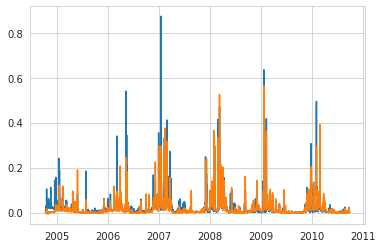

In [17]:
#### PLOT

plt.plot(df_test.index, obs)
plt.plot(df_test.index, output_test)

In [18]:
sim = output



obs=test_scaled['Q_'+catchment_str].values
obs = obs[model_params['sequence_length']:(model_params['sequence_length']+len(sim))]
#obs = (obs*stds.loc['Q_'+catchment_str])+mean.loc['Q_'+catchment_str]

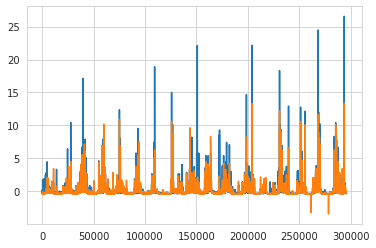

In [19]:
plt.plot(obs[:])
plt.plot(sim[:])

In [20]:
NSE = get_nse(obs[:], sim[:])
NSE

0.7533836796015411

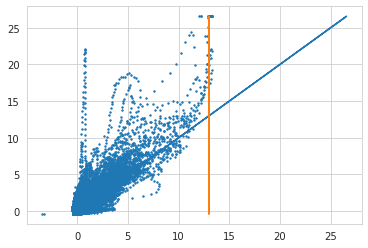

In [21]:
max_sim = np.ones(len(sim))*int(np.amax(sim))
plt.scatter(sim, obs, [2])
plt.plot(obs, obs)
plt.plot(max_sim, obs)



In [22]:

train_set = SequenceDataset(train_scaled, target, features, sequence_length=model_params['sequence_length'])
train_set.X = train_set.X[model_params['sequence_length']:, :]
train_set.y = train_set.y[model_params['sequence_length']:, ]
train_loader = DataLoader(train_set, batch_size = model_params['batch_size'], shuffle = False,  drop_last = True)




ann_model.eval()

with torch.no_grad():

    output = np.array([])

    for batch, _ in train_loader:
        y_pred,_  = ann_model(batch) # forward call
        new = y_pred.flatten().cpu().detach().numpy()
        output = np.append(output, new)
        
train_output_rescaled=(output*stds.loc['Q_'+catchment_str])+mean.loc['Q_'+catchment_str]
train_obs_df = train[512:len(train_output_rescaled)+512]
train_obs = train_obs_df.loc[:, 'Q_'+catchment_str]

NSE = get_nse(train_obs[:], train_output_rescaled[:])
NSE
df_res_train = pd.DataFrame(train_output_rescaled, columns=['Q_train'], index=train_obs_df.index)
train_o = train_obs.values
df_res_train['Q_obs'] = train_o
df_res_train.to_csv('results_train_best_model_'+catchment_str+'_Experiment_'+experiment)

In [23]:
df_res_train

,Q_train,Q_obs
Date,,
2010-10-11 16:00:00,0.001689,0.001562
2010-10-11 16:30:00,0.001722,0.001562
2010-10-11 17:00:00,0.001748,0.001562
2010-10-11 17:30:00,0.001772,0.001562
2010-10-11 18:00:00,0.001771,0.001562
...,...,...
2021-08-23 00:30:00,0.004910,0.000577
2021-08-23 01:00:00,0.004841,0.000577
2021-08-23 01:30:00,0.005065,0.000543
